In [1]:
import csv
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc
import math
import random

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_csv("../data/ortiz-bobea/data2/regdata_preferred_case.csv")
data_len = len(data.fd_tmean)

# Ortiz-bobea regression formula: 
# fd_log_tfp ~ fd_tmean + fd_tmean_sq + fd_prcp + fd_prcp_sq

# Build model

In [3]:
# year and country fixed effect coefficient matrices
year_mult_mat = [np.zeros(data_len) for year in set(data.year)]
country_mult_mat = [np.zeros(data_len) for country in set(data.ISO3)]
country_index = -1
curr_country = ""
for row_index, row in enumerate(data.itertuples()):
    if row.ISO3 != curr_country:
        country_index += 1
        curr_country = row.ISO3
    year_index = row.year - 1962
    country_mult_mat[country_index][row_index] = 1
    year_mult_mat[year_index][row_index] = 1

In [9]:
with pm.Model() as model:

    fd_temp_prior = pm.Normal("fd_temp_prior", np.mean(data.fd_tmean), np.std(data.fd_tmean))
    fd_temp_std = pm.HalfNormal("fd_temp_std", 10)
    # fd_temp_posterior = pm.Normal("fd_temp_posterior", fd_temp_prior, fd_temp_std, shape=(data_len))
    fd_temp_posterior = pm.Normal("fd_temp_posterior", fd_temp_prior, fd_temp_std, observed=data.fd_tmean)

    fd_sq_temp_prior = pm.Normal("fd_sq_temp_prior", np.mean(data.fd_tmean_sq), np.std(data.fd_tmean_sq))
    fd_sq_temp_std = pm.HalfNormal("fd_sq_temp_std", 10)
    # fd_sq_temp_posterior = pm.Normal("fd_sq_temp_posterior", fd_sq_temp_prior, fd_sq_temp_std, shape=(data_len))
    fd_sq_temp_posterior = pm.Normal("fd_sq_temp_posterior", fd_sq_temp_prior, fd_sq_temp_std, observed=data.fd_tmean_sq)

    fd_precip_prior = pm.Normal("fd_precip_prior", np.mean(data.fd_prcp), np.std(data.fd_prcp))
    fd_precip_std = pm.HalfNormal("fd_precip_std", 10)
    # fd_precip_posterior = pm.Normal("fd_precip_posterior", fd_precip_prior, fd_precip_std, shape=(data_len))
    fd_precip_posterior = pm.Normal("fd_precip_posterior", fd_precip_prior, fd_precip_std, observed=data.fd_prcp)

    fd_sq_precip_prior = pm.Normal("fd_sq_precip_prior", np.mean(data.fd_prcp_sq), np.std(data.fd_prcp_sq))
    fd_sq_precip_std = pm.HalfNormal("fd_sq_precip_std", 10)
    # fd_sq_precip_posterior = pm.Normal("fd_sq_precip_posterior", fd_sq_precip_prior, fd_sq_precip_std, shape=(data_len))
    fd_sq_precip_posterior = pm.Normal("fd_sq_precip_posterior", fd_sq_precip_prior, fd_sq_precip_std, observed=data.fd_prcp_sq)

    tfp_intercept = pm.Normal('tfp_intercept',0,10)
    fd_temp_tfp_coef = pm.Normal('fd_temp_tfp_coef',0,10)
    fd_sq_temp_tfp_coef = pm.Normal('fd_sq_temp_tfp_coef',0,10)
    fd_precip_tfp_coef = pm.Normal("fd_precip_tfp_coef",0,10)
    fd_sq_precip_tfp_coef = pm.Normal("fd_sq_precip_tfp_coef",0,10)

    year_coefs = pt.expand_dims(pm.Normal("year_coefs", 0, 10, shape=(len(set(data.year)))),axis=1)
    year_fixed_effects = pm.Deterministic("year_fixed_effects",pt.sum((year_coefs*year_mult_mat),axis=0))

    country_coefs = pt.expand_dims(pm.Normal("country_coefs", 0, 10, shape=(len(set(data.ISO3)))),axis=1)
    country_fixed_effects = pm.Deterministic("country_fixed_effects",pt.sum((country_coefs*country_mult_mat),axis=0))

    print(country_fixed_effects.eval().shape)
    print(year_fixed_effects.eval().shape)
    
    tfp_prior = pm.Deterministic(
        "tfp_prior",
        tfp_intercept +
        (fd_temp_tfp_coef * fd_temp_posterior) +
        (fd_sq_temp_tfp_coef * fd_sq_temp_posterior) +
        (fd_precip_tfp_coef * fd_precip_posterior) +
        (fd_sq_precip_tfp_coef * fd_sq_precip_posterior) +
        year_fixed_effects +
        country_fixed_effects
    )
    
    tfp_std = pm.HalfNormal('tfp_std', sigma=10)
    # tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std, shape=(data_len))
    tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std, observed=data.fd_log_tfp)

    # prior = pm.sample_prior_predictive()
    # trace = pm.sample()
    # posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

(9255,)
(9255,)
(9255,)
(9255,)


# Add observed data to model and sample

In [19]:
observed_model = observe(model, {
    "fd_temp_posterior":data.fd_tmean,
    "fd_sq_temp_posterior":data.fd_tmean_sq,
    "fd_precip_posterior":data.fd_prcp,
    "fd_sq_precip_posterior":data.fd_prcp_sq,
    "tfp_posterior":data.fd_log_tfp
})

with observed_model:
    prior = pm.sample_prior_predictive()
    trace = pm.sample()
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

with open ('../models/ortiz-bobea-reproduction-year-country-fixed-effects.pkl', 'wb') as buff:
    pkl.dump({
        "prior":prior,
        "trace":trace,
        "posterior":posterior
    },buff)

Sampling: [fd_precip_posterior, fd_precip_prior, fd_precip_std, fd_precip_tfp_coef, fd_sq_precip_posterior, fd_sq_precip_prior, fd_sq_precip_std, fd_sq_precip_tfp_coef, fd_sq_temp_posterior, fd_sq_temp_prior, fd_sq_temp_std, fd_sq_temp_tfp_coef, fd_temp_posterior, fd_temp_prior, fd_temp_std, fd_temp_tfp_coef, tfp_intercept, tfp_posterior, tfp_std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fd_temp_prior, fd_temp_std, fd_sq_temp_prior, fd_sq_temp_std, fd_precip_prior, fd_precip_std, fd_sq_precip_prior, fd_sq_precip_std, tfp_intercept, fd_temp_tfp_coef, fd_sq_temp_tfp_coef, fd_precip_tfp_coef, fd_sq_precip_tfp_coef, tfp_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 199 seconds.
Sampling: [fd_precip_posterior, fd_sq_precip_posterior, fd_sq_temp_posterior, fd_temp_posterior, tfp_posterior]


# Estimate historical anthropogenic effect on TFP

In [3]:
trace = pd.read_pickle('../models/ortiz-bobea-reproduction-year-country-fixed-effects.pkl')["trace"]
# trace = pd.read_pickle('../models/ortiz-bobea-reproduction.pkl')["trace"]

In [14]:
coef1 = np.mean(trace.posterior.fd_temp_tfp_coef.data)
coef2 = np.mean(trace.posterior.fd_sq_temp_tfp_coef.data)
coef3 = np.mean(trace.posterior.fd_precip_tfp_coef.data)
coef4 = np.mean(trace.posterior.fd_sq_precip_tfp_coef.data)
print(coef1, coef2, coef3, coef4)

-0.006519371207706483 -4.6465060074284566e-05 0.0001818307200354313 -1.8185374491776674e-07


In [5]:
gcms = {
    "can_esm_gcm" : pd.read_csv("../data/ortiz-bobea/climate_model_output/can_esm.csv").iloc[[-1]].values[0][2:],
    "cnrm_gcm" : pd.read_csv("../data/ortiz-bobea/climate_model_output/cnrm.csv").iloc[[-1]].values[0][2:],
    "had_gem_gcm" : pd.read_csv("../data/ortiz-bobea/climate_model_output/had_gem.csv").iloc[[-1]].values[0][2:],
    "ipsl_gcm" : pd.read_csv("../data/ortiz-bobea/climate_model_output/ipsl.csv").iloc[[-1]].values[0][2:],
    "miroc_gcm" : pd.read_csv("../data/ortiz-bobea/climate_model_output/miroc.csv").iloc[[-1]].values[0][2:],
    "mriesm_gcm" : pd.read_csv("../data/ortiz-bobea/climate_model_output/mriesm.csv").iloc[[-1]].values[0][2:],
    "res_bcc_gcm" : pd.read_csv("../data/ortiz-bobea/climate_model_output/res_bcc.csv").iloc[[-1]].values[0][2:]
}

In [6]:
gcm_sample = random.choices(list(gcms.keys()), k=2000)
bootstrap_sample = random.choices(list(range(500)), k=2000)
mean_res = []
for gcm in gcm_sample:
    for bootstrap in bootstrap_sample:
        mean_res.append(gcms[gcm][bootstrap])
print(np.mean(mean_res))
print(np.std(mean_res))

-0.33370947804754547
0.1761996176468353


In [7]:
# Green months
green_months = {}
green_month_data = pd.read_csv("../data/ortiz-bobea/data2/ndvi_co/peak_bottom_ndvi_month_country.csv")
for row in green_month_data.itertuples():
    peak = row[5]
    season = (peak-2,peak+2)
    if season[0] < 1:
        season = (season[0] + 12, season[1])
    if season[1] > 12:
        season = (season[0], season[1] - 12)
    green_months[row.ISO3] = season

In [8]:
# Revenue
revenue_data = pd.read_csv("../data/ortiz-bobea/data/TFP_USDA/revenue_shares.csv")
country_weights = {}
for row in revenue_data.itertuples():
    country_weights[row[3]] = np.mean(row[5:10])
weight_sum = sum(list(country_weights.values()))
for country, val in country_weights.items():
    country_weights[country] = val/weight_sum

In [85]:
# Historical climate means
country_climate_means = {}
country_1961_means = {}
ccm_file = pd.read_csv("../data/ortiz-bobea/data2/country_climate_means.csv")
for row in ccm_file.itertuples():
    country_climate_means[row[2]] = {"mean_temp":row[3], "mean_prcp":row[4]}
c1961_file = pd.read_csv("../data/ortiz-bobea/data2/country_climate_1961.csv")
for row in c1961_file.itertuples():
    country_1961_means[row[2]] = {"mean_temp":row[6],"mean_prcp":row[4]}

In [38]:
hist_data = pd.read_csv("../data/ortiz-bobea/data2/CMIP6_co/historical_BCC-CSM2-MR_1948-2020_cropland.csv")
hist_nat_data = pd.read_csv("../data/ortiz-bobea/data2/CMIP6_co/hist-nat_BCC-CSM2-MR_1948-2020_cropland.csv")

hist_temp, hist_nat_temp, hist_prcp, hist_nat_prcp = {key:[] for key in list(set(data.ISO3))}, {key:[] for key in list(set(data.ISO3))}, {key:[] for key in list(set(data.ISO3))}, {key:[] for key in list(set(data.ISO3))}

for year in set(data.year):
    for country in set(data.ISO3):

        hist_rows = hist_data.loc[(hist_data["year"] == year) & (hist_data["ISO3"] == country)]
        hist_rows = [row for row in hist_rows.itertuples() if row.ISO3 in green_months]
        hist_rows = [row for row in hist_rows if row.month >= green_months[row.ISO3][0] and row.month <= green_months[row.ISO3][1]]
    
        nat_rows = hist_nat_data.loc[(hist_nat_data["year"] == year) & (hist_nat_data["ISO3"] == country)]
        nat_rows = [row for row in nat_rows.itertuples() if row.ISO3 in green_months]
        nat_rows = [row for row in nat_rows if row.month >= green_months[row.ISO3][0] and row.month <= green_months[row.ISO3][1]]
        
        hist_temp[country].append(np.mean([((row.tasmax + row.tasmin)/2)-273.15 for row in hist_rows]))
        hist_prcp[country].append(np.sum([row.pr for row in hist_rows]))
    
        hist_nat_temp[country].append(np.mean([((row.tasmax + row.tasmin)/2)-273.15 for row in nat_rows]))
        hist_nat_prcp[country].append(np.sum([row.pr for row in nat_rows]))

/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [97]:
temp_hist_dev, temp_nat_dev, prcp_hist_dev, prcp_nat_dev = {}, {}, {}, {}
t1, t2, p1, p2 = {}, {}, {}, {}
t_diff, t_2_diff, p_diff, p_2_diff, = {}, {}, {}, {}

for country in set(data.ISO3):
    
    temp_hist_dev[country] = np.array(hist_temp[country]) - country_climate_means[country]["mean_temp"]
    temp_nat_dev[country] = np.array(hist_nat_temp[country]) - country_climate_means[country]["mean_temp"]
    prcp_hist_dev[country] = 1 + (np.array(hist_prcp[country]) - country_climate_means[country]["mean_prcp"]) / country_climate_means[country]["mean_prcp"]
    prcp_nat_dev[country] = 1 + (np.array(hist_nat_prcp[country]) - country_climate_means[country]["mean_prcp"]) / country_climate_means[country]["mean_prcp"]
    
    t1[country] = temp_nat_dev[country] + country_1961_means[country]["mean_temp"]
    t2[country] = temp_hist_dev[country] + country_1961_means[country]["mean_temp"]
    p1[country] = prcp_nat_dev[country] * country_1961_means[country]["mean_prcp"]
    p2[country] = prcp_hist_dev[country] * country_1961_means[country]["mean_prcp"]

    t_diff[country] = t2[country] - t1[country]
    p_diff[country] = p2[country] - p1[country]
    t_2_diff[country] = pow(t2[country],2) - pow(t1[country],2)
    p_2_diff[country] = pow(p2[country],2) - pow(p1[country],2)

In [98]:
country_res = {}
for country in set(data.ISO3):
    country_res[country] = t_diff[country]*coef1 + t_2_diff[country]*coef2 + p_diff[country]*coef3 + p_2_diff[country]*coef4
final_vals = []
for i in range(len(set(data.year))):
    this_year_vals = []
    for country, values in country_res.items():
        if not np.isnan(values[0]) and country in country_weights:
            this_year_vals.append(values[i] * country_weights[country])
    final_vals.append(np.sum(this_year_vals))

In [103]:
print(p_2_diff["AFG"])

[  5482.24003961  -3135.44544997   3084.94472679  -4552.61090759
    400.36490979  -2397.4871623    7488.77594986  -5332.99456831
  -1127.89502622    810.96464925  -1075.51174739   5788.03271666
   -190.93086901   5013.46244228  -1023.57940186   3953.31703351
  -3691.30660168  -1934.23961026   -334.12455079    142.77972253
    264.410429    -2095.83089984   1036.50935456    236.30563478
  -1676.42425912   5229.38509205   -515.91369766   -625.15665987
   2193.43065619   1119.16585987   -402.25656531    796.66492628
   1352.42330955   1959.18699124   1625.65048935 -10068.30001237
  -1969.78451802    -36.88518346   1076.3982163    6413.19688053
   -887.99945354  -2129.22656787   4829.04010427   2521.39612216
  -3830.93865977   -396.78491473  -3244.99668606  -3467.62748161
   3345.0816945   -7557.34557534   -507.23246979  -2352.42412427
   -200.21469177    357.87926221]


In [57]:
model_0 = do(model, {
    "fd_temp_posterior":np.zeros(data_len),
    "fd_sq_temp_posterior":np.zeros(data_len),
    "fd_precip_posterior":np.zeros(data_len),
    "fd_sq_precip_posterior":np.zeros(data_len),
    "tfp_intercept":0,
    "fd_temp_tfp_coef":-0.006519371207706483,
    "fd_sq_temp_tfp_coef":-4.6465060074284566e-05,
    "fd_precip_tfp_coef":0.0001818307200354313,
    "fd_sq_precip_tfp_coef":-1.8185374491776674e-07
})
model_1 = do(model, {
    "fd_temp_posterior":temp_diff,
    "fd_sq_temp_posterior":temp_sq_diff,
    "fd_precip_posterior":prcp_diff,
    "fd_sq_precip_posterior":prcp_sq_diff,
    "tfp_intercept":0,
    "fd_temp_tfp_coef":-0.006519371207706483,
    "fd_sq_temp_tfp_coef":-4.6465060074284566e-05,
    "fd_precip_tfp_coef":0.0001818307200354313,
    "fd_sq_precip_tfp_coef":-1.8185374491776674e-07

})

model_0_tfp_samples = pm.sample_posterior_predictive(
    trace,
    model=model_0,
    var_names=["tfp_posterior","fd_temp_posterior","fd_sq_temp_posterior","fd_precip_posterior","fd_sq_precip_posterior"]
)
model_1_tfp_samples = pm.sample_posterior_predictive(
    trace,
    model=model_1,
    var_names=["tfp_posterior","fd_temp_posterior","fd_sq_temp_posterior","fd_precip_posterior","fd_sq_precip_posterior"]
)

Sampling: [tfp_posterior]


Sampling: [tfp_posterior]


In [58]:
print(np.mean(model_0_tfp_samples.posterior_predictive.tfp_posterior.data))
print(np.mean(model_1_tfp_samples.posterior_predictive.tfp_posterior.data))

-4.913528029512273e-06
-0.003592186441799411


<Axes: ylabel='Probability'>

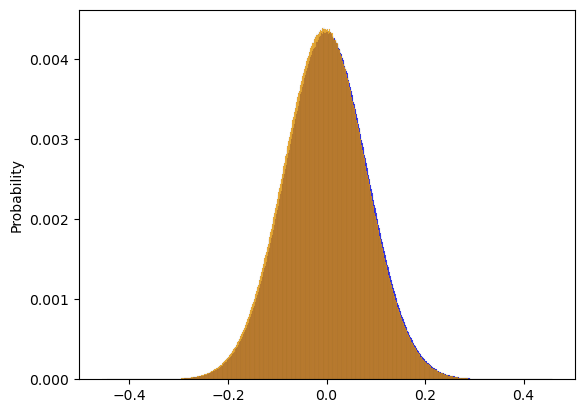

In [59]:
fig, ax = plt.subplots()
sns.histplot(data=np.array(model_0_tfp_samples.posterior_predictive.tfp_posterior.data.flatten()), stat='probability', bins=1000, ax=ax, color="blue", label = "Without Anthropogenic Climate Change")
sns.histplot(data=np.array(model_1_tfp_samples.posterior_predictive.tfp_posterior.data.flatten()), stat='probability', bins=1000, ax=ax, color="orange", label = "With Anthropogenic Climate Change")
# ax.legend()